In [1]:
import os, json
import importlib
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import seaborn as sns
from utils.data import DataTree

import snapfish2 as sf
importlib.reload(sf)

<module 'snapfish2' from '/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/__init__.py'>

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
out_dire = "../123ACElog/013125"

In [4]:
dtree = DataTree("../data")
dfs = []
for k in ["rep1", "rep2"]:
    data_name = dtree["takei_nature_2021","25Kb",k]
    df = sf.MulFish(data_name).data
    df["Trace_ID"] = k + "_" + df["Trace_ID"]  # Ensure Trace_ID is unique
    df["Replicate"] = k
    df["X"] *= 103; df["Y"] *= 103; df["Z"] *= 250  # Convert to nm
    dfs.append(df)
mfr = sf.MulFish(pd.concat(dfs, ignore_index=True))
del df, dfs

## TAD and hierarchical TADs

In [5]:
chr_id = "chr3"
chr_df_pivoted, arr = sf.utils.load.to_very_wide(mfr[chr_id])
d1d = chr_df_pivoted.index.values
med_mat = np.nanmedian(np.sqrt(np.sum(np.square(arr), axis=1)), axis=0)

In [6]:
tdc = sf.domain.TADCaller(mfr[chr_id], 1e5, "carr")
df1 = tdc.by_insulation(.04, 2)
bedpe1 = tdc.to_bedpe(df1, "insulation", False)
df2 = tdc.by_pval(.1)
bedpe2 = tdc.to_bedpe(df2, "stat", True)

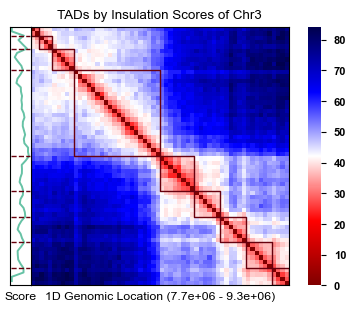

In [64]:
fig, ax = plt.subplots(figsize=(3.5, 3))
sf.pl.pairwise_heatmap(
    med_mat, ax=ax, cbar=True, 
    title=f"TADs by Insulation Scores of {chr_id.title()}",
)
caxs = sf.pl.plot_TAD_boundary(
    df1[df1["c1"]==chr_id], 
    bedpe1[bedpe1["c1"]==chr_id],
    cols=["insulation"], 
    tad_colors=[plt.get_cmap("Reds")(500) for i in range(10)],
    line_colors=[plt.get_cmap("Set2")(i) for i in range(10)],
    line_names=["Score"],
    linewidth=1, alpha=1, ax=ax
)
ax.xaxis.set_label_position("bottom")
ax.set(xlabel=f"1D Genomic Location ({d1d.min():.1e} - {d1d.max():.1e})")
out_fname = os.path.join(out_dire, f"TAD_by_insulation_{chr_id}_raw.pdf")
fig.savefig(out_fname, bbox_inches="tight")

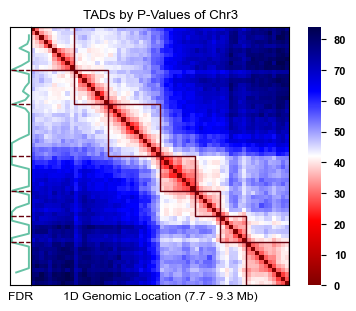

In [67]:
bedpe2r = tdc.to_bedpe(df2, "stat", False)
fig, ax = plt.subplots(figsize=(3.5, 3))
sf.pl.pairwise_heatmap(
    med_mat, ax=ax, cbar=True,
    title=f"TADs by P-Values of {chr_id.title()}",
)
caxs = sf.pl.plot_TAD_boundary(
    df2[df2["c1"]==chr_id], 
    bedpe2r[bedpe2r["c1"]==chr_id],
    cols=["fdr"], 
    tad_colors=[plt.get_cmap("Reds")(500) for i in range(10)],
    line_colors=[plt.get_cmap("Set2")(i) for i in range(10)],
    line_names=["FDR"],
    linewidth=1, alpha=1, ax=ax
)
ax.xaxis.set_label_position("bottom")
ax.set(xlabel=f"1D Genomic Location ({d1d.min()/1e6:.1f} - {d1d.max()/1e6:.1f} Mb)")
out_fname = os.path.join(out_dire, f"TAD_by_pval_{chr_id}_raw.pdf")
fig.savefig(out_fname, bbox_inches="tight")

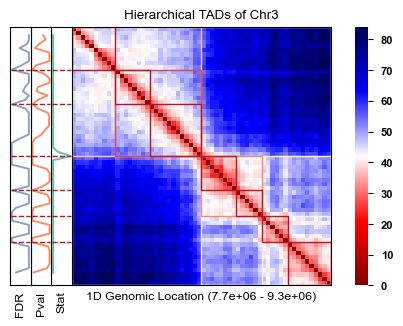

In [71]:
fig, ax = plt.subplots(figsize=(4, 3))
sf.pl.pairwise_heatmap(
    med_mat, ax=ax, cbar=True,
    title=f"Hierarchical TADs of {chr_id.title()}",
)
caxs = sf.pl.plot_TAD_boundary(
    df2[df2["c1"]==chr_id], 
    bedpe2[bedpe2["c1"]==chr_id],
    cols=["stat", "pval", "fdr"], 
    tad_colors=[plt.get_cmap("Reds_r")(i*50+50) for i in range(10)],
    line_colors=[plt.get_cmap("Set2")(i) for i in range(10)],
    line_names=["Stat", "Pval", "FDR"],
    linewidth=1, alpha=1, ax=ax, rotation=90
)
ax.xaxis.set_label_position("bottom")
ax.set(xlabel=f"1D Genomic Location ({d1d.min():.1e} - {d1d.max():.1e})")
out_fname = os.path.join(out_dire, f"TAD_by_pval_tree_{chr_id}_raw.pdf")
fig.savefig(out_fname, bbox_inches="tight")

## Adding random errors

In [11]:
noised = sf.MulFish(mfr.data.copy())
np.random.seed(200)
noised.data["Z"] += stats.norm.rvs(size=(len(mfr.data["Z"])), scale=50)

In [12]:
tdc2 = sf.domain.TADCaller(noised[chr_id], 1e5, "carr")
df1 = tdc2.by_insulation(.04, 2)
bedpe1 = tdc2.to_bedpe(df1, "insulation", False)
df2 = tdc2.by_pval(.1)
bedpe2 = tdc2.to_bedpe(df2, "stat", True)

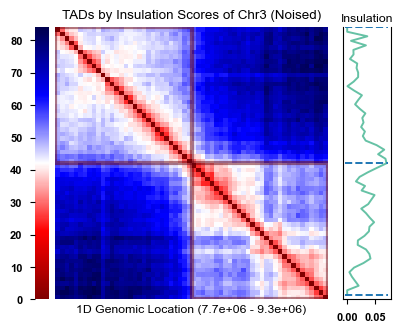

In [14]:
fig, axes = sf.pl.plot_TAD_boundary(
    df1[df1["c1"]==chr_id], 
    bedpe1[bedpe1["c1"]==chr_id],
    cols=["insulation"], 
    tad_colors=[plt.get_cmap("Reds")(500) for i in range(10)],
    line_colors=[plt.get_cmap("Set2")(i) for i in range(10)],
    # line_lim={"stat":(0, 200)},
    linewidth=3, alpha=.5
)
sf.pl.pairwise_heatmap(
    med_mat, ax=axes[0], cbar=True, 
    cbar_kws={"location":"left", "pad":0.02},
    title=f"TADs by Insulation Scores of {chr_id.title()} (Noised)",
)
axes[0].xaxis.set_label_position("bottom")
axes[0].set(xlabel=f"1D Genomic Location ({d1d.min():.1e} - {d1d.max():.1e})")
out_fname = os.path.join(out_dire, f"TAD_by_insulation_{chr_id}_noised.pdf")
fig.savefig(out_fname, bbox_inches="tight")

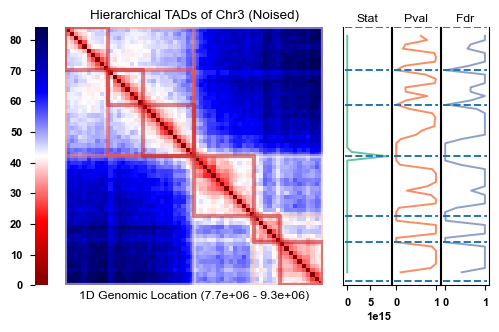

In [15]:
fig, axes = sf.pl.plot_TAD_boundary(
    df2[df2["c1"]==chr_id], 
    bedpe2[bedpe2["c1"]==chr_id],
    cols=["stat", "pval", "fdr"], 
    tad_colors=[plt.get_cmap("Reds_r")(i*50+50) for i in range(10)],
    line_colors=[plt.get_cmap("Set2")(i) for i in range(10)],
    # line_lim={"stat":(0, 100)},
    linewidth=3, alpha=.5
)
sf.pl.pairwise_heatmap(
    med_mat, ax=axes[0], cbar=True, 
    cbar_kws={"location":"left", "pad":0.05},
    title=f"Hierarchical TADs of {chr_id.title()} (Noised)",
)
axes[0].xaxis.set_label_position("bottom")
axes[0].set(xlabel=f"1D Genomic Location ({d1d.min():.1e} - {d1d.max():.1e})")
out_fname = os.path.join(out_dire, f"TAD_by_pval_tree_{chr_id}_noised.pdf")
fig.savefig(out_fname, bbox_inches="tight")

## Correlation with ChIP-seq

In [16]:
chip_tdc = sf.domain.TADCaller(mfr.data, 1e5, "carr")
df_by_insulation = chip_tdc.by_insulation(0.04, 2)
bedpe_by_insulation = chip_tdc.to_bedpe(df_by_insulation, "insulation", False)
df_by_pval = chip_tdc.by_pval(.1)
bedpe_by_pval = chip_tdc.to_bedpe(df_by_pval, "stat", False)

In [18]:
from utils.utils import tad_enrichment_row
chipseq_fpath = "../data/chipseq_mesc/{}_ChIPseq_mESC.csv"
enriched_boundary = ["H3K36me3", "H3K4me3", "POLR2A", "CTCF", "H3K9me3"]
enrich = []
for target in enriched_boundary:
    chip_df = pd.read_csv(chipseq_fpath.format(target), sep="\t")
    d1 = tad_enrichment_row(df_by_insulation, chip_df)
    d1["method"] = "by_insulation"
    d2 = tad_enrichment_row(df_by_pval, chip_df)
    d2["method"] = "by_pval"
    d1["target"] = d2["target"] = target
    enrich.extend([d1, d2])
enrich = pd.DataFrame(enrich)
enrich["peak_frac"] = enrich["peak_shared"]/enrich["num_peaks"]
enrich["non_peak_frac"] = enrich["non_peak_shared"]/enrich["num_non_peaks"]

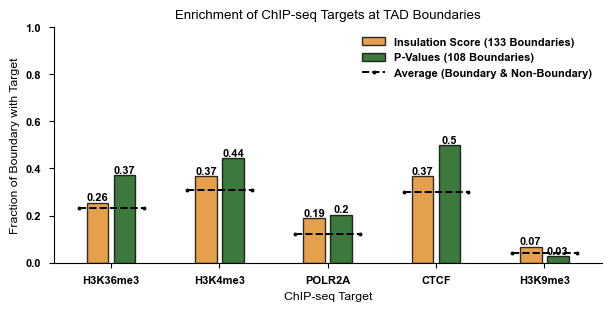

In [19]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(
    enrich, x="target", y="peak_frac", hue="method",  ax=ax, 
    width=.5, dodge=10, gap=0.2, alpha=.8, edgecolor="k", linewidth=1,
    palette={"by_insulation": "darkorange", "by_pval": "darkgreen"},
)
ax.bar_label(
    ax.containers[0], labels=ax.containers[0].datavalues.round(2), fontsize=8
)
ax.bar_label(
    ax.containers[1], labels=ax.containers[1].datavalues.round(2), fontsize=8
)
ax.set(xlabel="ChIP-seq Target", ylabel="Fraction of Boundary with Target")
ax.set(ylim=(0,1), title="Enrichment of ChIP-seq Targets at TAD Boundaries")

n1 = enrich[enrich["method"]=="by_insulation"]["num_peaks"].iloc[0]
n2 = enrich[enrich["method"]=="by_pval"]["num_peaks"].iloc[0]
label_dict = {
    "by_insulation": f"Insulation Score ({n1} Boundaries)",
    "by_pval": f"P-Values ({n2} Boundaries)",
    "t": "Average (Boundary & Non-Boundary)"
}

for i, r in enrich[enrich["method"]=="by_pval"].iterrows():
    avg = (r["peak_shared"]+r["non_peak_shared"])/\
        (r["num_peaks"]+r["num_non_peaks"])
    ax.plot([-.3+(i-1)/2, .3+(i-1)/2], [avg, avg], ".--k", label="t")

handles, labels = ax.get_legend_handles_labels()
labels = [label_dict[t] for t in labels[:3]]
ax.legend(handles=handles[:3], labels=labels, loc="best")
out_fname = os.path.join(out_dire, "chipseq_tad_raw.pdf")
fig.savefig(out_fname, bbox_inches="tight")

In [21]:
tdc_noised = sf.domain.TADCaller(noised.data, 1e5, "carr")
df_by_insul_n = tdc_noised.by_insulation(0.04, 2)
bedpe_by_insul_n = tdc_noised.to_bedpe(df_by_insul_n, "insulation", False)
df_by_pval_n = tdc_noised.by_pval(.1)
bedpe_by_pval_n = tdc_noised.to_bedpe(df_by_pval_n, "stat", False)

In [22]:
chipseq_fpath = "../data/chipseq_mesc/{}_ChIPseq_mESC.csv"
enriched_boundary = ["H3K36me3", "H3K4me3", "POLR2A", "CTCF", "H3K9me3"]
enrich_n = []
for target in enriched_boundary:
    chip_df = pd.read_csv(chipseq_fpath.format(target), sep="\t")
    d1 = tad_enrichment_row(df_by_insul_n, chip_df)
    d1["method"] = "by_insulation"
    d2 = tad_enrichment_row(df_by_pval_n, chip_df)
    d2["method"] = "by_pval"
    d1["target"] = d2["target"] = target
    enrich_n.extend([d1, d2])
enrich_n = pd.DataFrame(enrich_n)
enrich_n["peak_frac"] = enrich_n["peak_shared"]/enrich_n["num_peaks"]
enrich_n["non_peak_frac"] = enrich_n["non_peak_shared"]/enrich_n["num_non_peaks"]

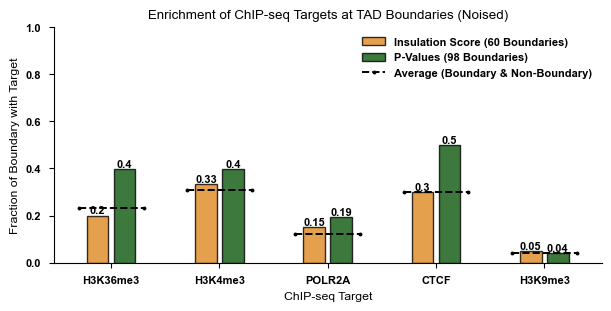

In [23]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(
    enrich_n, x="target", y="peak_frac", hue="method",  ax=ax, 
    width=.5, dodge=10, gap=0.2, alpha=.8, edgecolor="k", linewidth=1,
    palette={"by_insulation": "darkorange", "by_pval": "darkgreen"},
)
ax.bar_label(
    ax.containers[0], labels=ax.containers[0].datavalues.round(2), fontsize=8
)
ax.bar_label(
    ax.containers[1], labels=ax.containers[1].datavalues.round(2), fontsize=8
)
ax.set(xlabel="ChIP-seq Target", ylabel="Fraction of Boundary with Target")
ax.set(title="Enrichment of ChIP-seq Targets at TAD Boundaries (Noised)")
ax.set(ylim=(0,1))

n1 = enrich_n[enrich_n["method"]=="by_insulation"]["num_peaks"].iloc[0]
n2 = enrich_n[enrich_n["method"]=="by_pval"]["num_peaks"].iloc[0]
label_dict = {
    "by_insulation": f"Insulation Score ({n1} Boundaries)",
    "by_pval": f"P-Values ({n2} Boundaries)",
    "t": "Average (Boundary & Non-Boundary)"
}

for i, r in enrich_n[enrich_n["method"]=="by_pval"].iterrows():
    avg = (r["peak_shared"]+r["non_peak_shared"])/\
        (r["num_peaks"]+r["num_non_peaks"])
    ax.plot([-.3+(i-1)/2, .3+(i-1)/2], [avg, avg], ".--k", label="t")

handles, labels = ax.get_legend_handles_labels()
labels = [label_dict[t] for t in labels[:3]]
ax.legend(handles=handles[:3], labels=labels, loc="best")
out_fname = os.path.join(out_dire, "chipseq_tad_noised.pdf")
fig.savefig(out_fname, bbox_inches="tight")

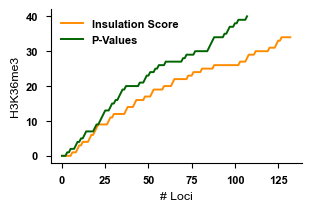

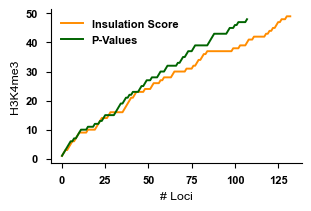

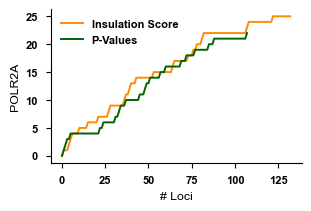

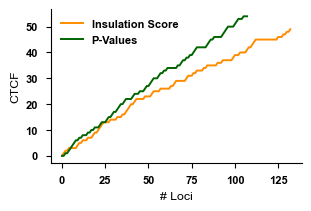

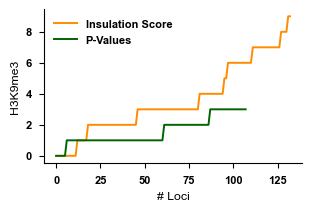

In [24]:
targets = ["H3K36me3", "H3K4me3", "POLR2A", "CTCF", "H3K9me3"]
d1, d2 = df_by_insulation, df_by_pval
for target in enriched_boundary:
    chip_df = pd.read_csv(chipseq_fpath.format(target), sep="\t")
    d1 = tad_enrichment_row(d1, chip_df, target)
    d1[target] = d1[d1["peak"]].sort_values(
        "insulation", ignore_index=True, ascending=False
    )[target].cumsum()#/np.sum(d1[target])
    d2 = tad_enrichment_row(d2, chip_df, target)
    d2[target] = d2[d2["peak"]].sort_values(
        "stat", ignore_index=True, ascending=False
    )[target].cumsum()#/np.sum(d2[target])
d1 = d1[targets].reset_index(names="# Loci")
d1["method"] = "Insulation Score"
d2 = d2[targets].reset_index(names="# Loci")
d2["method"] = "P-Values"
d = pd.concat([d1, d2], ignore_index=True)
palette = {"Insulation Score": "darkorange", "P-Values": "darkgreen"}
for target in targets:
    fig, ax = plt.subplots(figsize=(3, 2))
    sns.lineplot(d, x="# Loci", y=target, hue="method", palette=palette, ax=ax)
    ax.legend(loc="best")
    out_fname = os.path.join(out_dire, f"{target}_tad_curve.pdf")
    fig.savefig(out_fname, bbox_inches="tight")

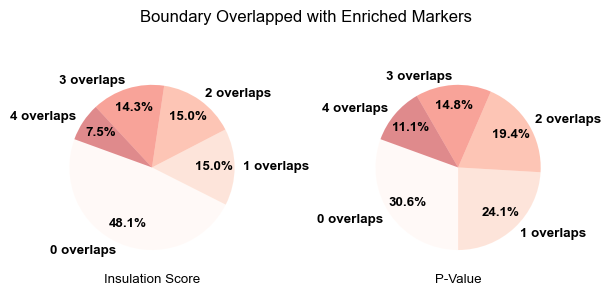

In [25]:
targets = ["H3K36me3", "H3K4me3", "POLR2A", "CTCF"]
d1, d2 = df_by_insulation, df_by_pval
for target in targets:
    chip_df = pd.read_csv(chipseq_fpath.format(target), sep="\t")
    d1 = tad_enrichment_row(d1, chip_df, target)
    d2 = tad_enrichment_row(d2, chip_df, target)
fig, axes = plt.subplots(1, 2, figsize=(6,3))
colors = [plt.get_cmap("Reds")(i*50) for i in range(len(targets)+1)]
overlap1 = d1[d1["peak"]][targets].sum(axis=1).values
labels, count = np.unique(overlap1, return_counts=True)
fontsize = plt.rcParams["axes.titlesize"]
axes[0].pie(
    count, labels=[f"{t} overlaps" for t in labels],
    autopct="%1.1f%%", startangle=160, 
    labeldistance=1.1, pctdistance=.75,
    wedgeprops=dict(alpha=.5), colors=colors,
    textprops=dict(fontsize=fontsize)
)
axes[0].set_title("Insulation Score", y=-.1)
overlap2 = d2[d2["peak"]][targets].sum(axis=1).values
labels, count = np.unique(overlap2, return_counts=True)
axes[1].pie(
    count, labels=[f"{t} overlaps" for t in labels],
    autopct="%1.1f%%", startangle=160, 
    labeldistance=1.1, pctdistance=.75,
    wedgeprops=dict(alpha=.5), colors=colors,
    textprops=dict(fontsize=fontsize)
)
axes[1].set_title("P-Value", y=-.1)
fig.suptitle("Boundary Overlapped with Enriched Markers")
out_fname = os.path.join(out_dire, "tad_chip_raw_pie.pdf")
fig.savefig(out_fname, bbox_inches="tight")

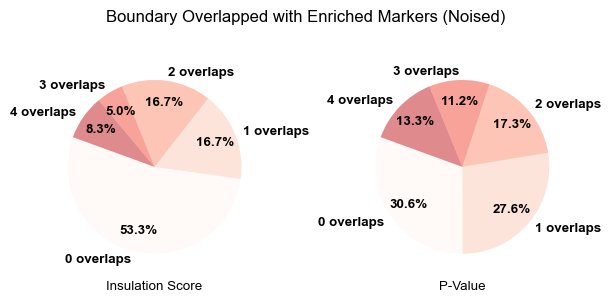

In [26]:
targets = ["H3K36me3", "H3K4me3", "POLR2A", "CTCF"]
d1, d2 = df_by_insul_n, df_by_pval_n
for target in targets:
    chip_df = pd.read_csv(chipseq_fpath.format(target), sep="\t")
    d1 = tad_enrichment_row(d1, chip_df, target)
    d2 = tad_enrichment_row(d2, chip_df, target)
fig, axes = plt.subplots(1, 2, figsize=(6,3))
colors = [plt.get_cmap("Reds")(i*50) for i in range(len(targets)+1)]
overlap1 = d1[d1["peak"]][targets].sum(axis=1).values
labels, count = np.unique(overlap1, return_counts=True)
axes[0].pie(
    count, labels=[f"{t} overlaps" for t in labels],
    autopct="%1.1f%%", startangle=160, 
    labeldistance=1.1, pctdistance=.75,
    wedgeprops=dict(alpha=.5), colors=colors,
    textprops=dict(fontsize=fontsize)
)
axes[0].set_title("Insulation Score", y=-.1)
overlap2 = d2[d2["peak"]][targets].sum(axis=1).values
labels, count = np.unique(overlap2, return_counts=True)
axes[1].pie(
    count, labels=[f"{t} overlaps" for t in labels],
    autopct="%1.1f%%", startangle=160, 
    labeldistance=1.1, pctdistance=.75,
    wedgeprops=dict(alpha=.5), colors=colors,
    textprops=dict(fontsize=fontsize)
)
axes[1].set_title("P-Value", y=-.1)
fig.suptitle("Boundary Overlapped with Enriched Markers (Noised)")
out_fname = os.path.join(out_dire, "tad_chip_noised_pie.pdf")
fig.savefig(out_fname, bbox_inches="tight")